## Understanding Loop Dataset
This notebook tries provides details on the structure of the Loop dataset and makes suggestions how to process the data.

## The Loop study

**Title**: An Observational Study of Individuals with Type 1 Diabetes Using the Loop System for Automated Insulin Delivery: The Loop Observational Study (LOS)


**Description**: Passive data collection to collect data on the efficacy, safety, usability, and quality of life/ psychosocial effects of the Loop System
    
**Devices**: insulin pump and a Dexcom or Medtronic CGM

**Study Population**: People of any age with Type 1 Diabetes

# Data
The study data folder is named **Loop study public dataset 2023-01-31**

From the DataGlossary.rtf file, the following relevant files were identified which are stored in the **Data Tables** subfolder.

* **LOOPDeviceBasal#.txt**: #:1-3. LOOP study Basal data exported from Tidepool
* **LOOPDeviceBolus.txt**: Bolus data exported from Tidepool
* **LOOPDeviceCGM#.txt**: #;1-6. List of cgm data dowloaded 
* **PtRoster.txt**: Patient Roster

These are csv files ("|" separator) and host many columns related to the Tandem pump events and the Dexcom cgm. The glossary provides information about each column. Each file contains a limited amount of columns compared to the FLAIR data. Below are **all** of the columns contained in each file

## LOOPDeviceBasal1-3
* **PtID**: Patient ID
* **DeviceDtTm**: Local device date and time; note not present in most rows because unavailable in Tidepool data source
* **UTCDtTm**: Date and time with timezone offset
* **Duration**: Actual number of milliseconds basal will be in effect
* **ExpectedDuration**: Expected number of milliseconds basal will be in effect
* **Percnt**: Percentage of suppressed basal that should be delivered
* **Rate**: Number of units per hour
* **ExtendedBolusPortion**: Flag distinguishing the immediate (Now) portion of the bolus (if any) from the extended (Later) portion [Now, Later]
* **SuprBasalType**: Suppressed basal delivery type (suppressed basal = basal event not being delivered because this one is active)
* **SuprDuration**: Suppressed duration
* **SuprRate**: Suppressed rate
* **TmZnOffset**: Timezone offset

## LOOPDeviceBolus
* **PtID**: Patient ID
* **DeviceDtTm**: Local device date and time; note not present in most rows because unavailable in Tidepool data source
* **UTCDtTm**: Device date and time (with timezone offset)
* **BolusType**: Subtype of data (ex: "Normal" and "Square" are subtypes of "Bolus" type)
* **Normal**: Number of units of normal bolus
* **ExpectedNormal**: Expected number of units of normal bolus
* **Extended**: Number of units for extended delivery
* **ExpectedExtended**: Expected number of units for extended delivery
* **Duration**: Time span over which the bolus was delivered (milliseconds for Tidepool data, minutes for Diasend data)
* **ExpectedDuration**: Expected time span over which the bolus should have been delivered (milliseconds for Tidepool data, minutes for Diasend data)
* **TmZnOffset**: Timezone offset
* **OriginName**: Data origin name
* **OriginType**: Data origin type

## LOOPDeviceCGM1-6
* **PtID**: Patient ID
* **DeviceDtTm**: Local device date and time; note not present in most rows because unavailable in Tidepool data source
* **UTCDtTm**: Device date and time (with timezone offset)
* **CGMVal**: Glucose reading from the CGM (in mmol/L from Tidepool)
* **Units**: Glucose reading units
* **DexInternalDtTm**: Dexcom Internal date and time
* **DexTrend**: Dexcom trend
* **TmZnOffset**: Timezone offset


## Notes
* There are 3 Basal files, 1 Bolus file, and 6 CGM files
* The Basal files are 2.9GB, 2.9GB, and 1.35GB in size
* The bolus file is 349 MB
* The CGM files are 2.14, 2.24, 2.3, 2.31, 2.33, and 1.53 GB
* There is exercise data contained within LOOPDeviceExercise
* There is food data within LOOPDeviceFood
* There are more patient IDs in the CGM files than in the Basal and Bolus files
## Questions
* how do we determine if the data is uploaded from Tidepool of Diasend? This effects the extended boluses

In [1]:
import os, sys
from datetime import datetime, timedelta, timezone
import numpy as np
import pandas as pd
from dask import dataframe as dd

%matplotlib notebook
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(),'..'))
from src import cdf
from src import postprocessing

#get the file path
current_dir = os.getcwd(); 
raw_path = os.path.join(current_dir, '..', 'data', 'raw')
out_path = os.path.join(current_dir, '..', 'data', 'out')
study_name = 'Loop study public dataset 2023-01-31'
loop_path = os.path.join(raw_path, study_name)

### CGM

In [2]:
df_patient= pd.read_csv(os.path.join(loop_path, 'Data Tables', 'PtRoster.txt'), sep='|')

In [ ]:

df_cgm = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceCGM1.txt'), sep='|',
                     usecols=['PtID', 'DeviceDtTm', 'TmZnOffset', 'UTCDtTm', 'RecordType', 'CGMVal', 'Units'])

display(df_patient.head(3))
display(df_patient.PtTimezoneOffset.value_counts())

memory_usage = df_cgm.memory_usage().sum() / 1024**2
print(f"Memory usage: {memory_usage:.2f} MB (before optimization)")

df_cgm['UTCDtTm'] = pd.to_datetime(df_cgm.UTCDtTm, format='%Y-%m-%d %H:%M:%S')
df_cgm['DeviceDtTm'] = pd.to_datetime(df_cgm.DeviceDtTm, format='%Y-%m-%d %H:%M:%S')
df_cgm['TmZnOffset'] = pd.to_timedelta(df_cgm.TmZnOffset, unit='minute')

#df_cgm['PtID'] = df_cgm.PtID.astype('category')

df_cgm = df_cgm.loc[df_cgm.RecordType == 'CGM'].drop(columns=['RecordType'])
df_cgm = df_cgm.drop(columns=['Units'])

memory_usage = df_cgm.memory_usage().sum() / 1024**2
print(f"Memory usage: {memory_usage:.2f} MB (after optimization)")


In [ ]:
def count_na(series):
    return series.isna().sum()
display(df_cgm.agg(['count', count_na, 'nunique']).T)

,count,count_na,nunique
PtID,18912614,0,589
DeviceDtTm,6128194,12784420,5629581
UTCDtTm,18912614,0,14581839
CGMVal,18912614,0,315660
TmZnOffset,5917165,12995449,15


### Datetimes
Are these local times? This is what the glossary says:
 - `DeviceDtTm`: Local device date and time; note not present in most rows because unavailable in Tidepool data source
 - `UTCDtTm`: Device date and time adjusted with timezone offset
 -`DexInternalDtTm` Dexcom Internal date and time
 -`TmZnOffset`: Timezone offset

It is unclear how to obtain local times and which data to trust. We therefore asked JAEB the following questions.

`Time Zones`: The UTCDtTm field does not include timezone information and TmZnOffset is only available when DeviceDtTm exists, which is rare. Local time might need to be extrapolated using backward / forward filling or using PtTimezoneOffset of the patient roster, which may not be reliable over long periods. How can local times be obtained for all patients, given the limited availability of DeviceDtTm and the potential inaccuracy of PtTimezoneOffset 
> Answer: When we did the analysis, we used participant zip codes to estimate a local time. However, the zip code is not available in the public dataset. Instead, the variable PTTimezoneOffset in the PtRoster dataset can be applied to all UTC times to obtain a local time. During daylight savings, the offset should be reduced by 1.  This won’t be a perfect measure of the local time but should be a close approximation.

`Dexcom Times`: Are Dexcom DexInternalDtTm times in local time or UTC? 
> We did not use this variable because it is missing for the majority of cases.  We believe that it was only available in downloads from personal CGMs but not available in the data uploaded by Tidepool.  It may be the local time but may need to reach out to Dexcom to confirm this.



It remains unclear weather UTCDtTm is in fact in local time or utc. Let's check. Let's plot the distribution of CGM values over the course of a day using a sample of 10.000 values. We checked and all datetimes have a length 0f 19 characters, following this format `2018-06-06 03:52:32`

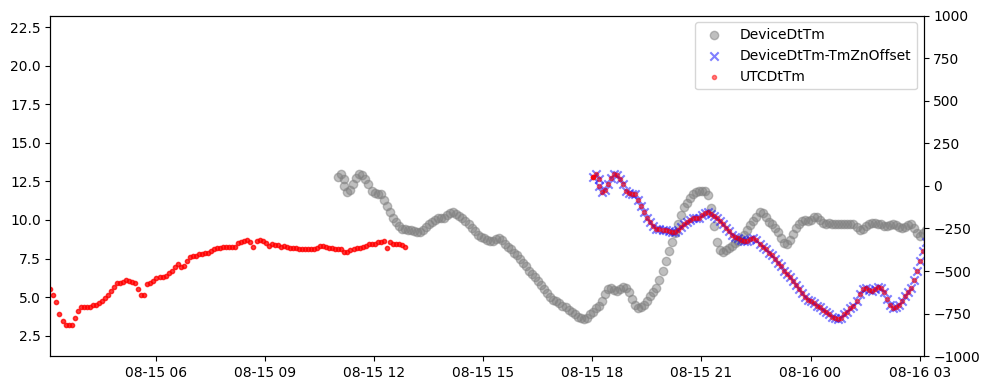

In [ ]:
%matplotlib inline
# set up plot
pt_grps = df_cgm.groupby('PtID', observed=False)
subframe = pt_grps.get_group(1173).copy()
subframe['AdjustedDtTm'] = subframe.DeviceDtTm - pd.to_timedelta(subframe.TmZnOffset, unit='minute')

temp = subframe.dropna(subset=['DeviceDtTm']).sort_values(['DeviceDtTm'])

fig, ax = plt.subplots(figsize=(10, 4)); twinx = ax.twinx()
offset=4.5

ax.scatter(temp.DeviceDtTm, temp.CGMVal, label='DeviceDtTm', marker='o',alpha=0.5, color='gray')
ax.scatter(temp.AdjustedDtTm, temp.CGMVal, label='DeviceDtTm-TmZnOffset', marker='x',alpha=0.5,color='blue')

temp = subframe.dropna(subset=['UTCDtTm']).sort_values(['UTCDtTm'])
ax.scatter(temp.UTCDtTm, temp.CGMVal, label='UTCDtTm', marker='.',alpha=0.5,color='red')
twinx.plot(temp.UTCDtTm, temp.TmZnOffset, label='TmZnOffset')

ax.set_xlim(temp.UTCDtTm.min()+timedelta(days=offset), temp.UTCDtTm.min()+timedelta(days=offset+1))
twinx.set_ylim(-1000, 1000); ax.legend(); plt.tight_layout()
plt.show()
del subframe, temp

**Approach:** I check if DataDtTm is the same as `UTCDtTm` if adjusted by timezone offset. If they are the same, i know that `UTCDtTm` is really unix and not local datetime. I drop all nan rows, this gives me a dataset that has both datetime and utxdatetimes. Then i subtract `TmZnOffset` from DeviceDtTm (supposedely local) and check if the resulting values are equal to the `UTCDtTm` datetime. I use the difference and provide a summary of thoe. At this point i stop and re-evaluate. I try to do this in one Pomodoro. After the pomodoro i stop and re-evaluate. 

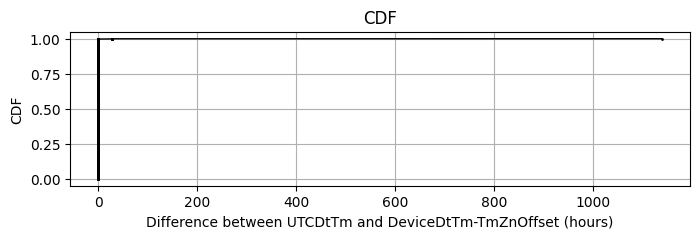

In [ ]:
%matplotlib inline
temp = df_cgm.sample(10000).dropna(subset=['UTCDtTm','DeviceDtTm','TmZnOffset'],how='any').copy()
temp['UTCDtTm'] = pd.to_datetime(temp.UTCDtTm)
temp['DeviceDtTm'] = pd.to_datetime(temp.DeviceDtTm)

temp.loc[:,'AdjustedDtTm_UTC'] = temp.DeviceDtTm - pd.to_timedelta(temp.TmZnOffset, unit='minute')
temp.loc[:,'Diff'] = (temp.UTCDtTm - temp.AdjustedDtTm_UTC).dt.total_seconds()/3600
#display(temp.sort_values('Diff', ascending=False).head(3))
#display(temp.sort_values('Diff', ascending=False).tail(3))
#display(temp.Diff.describe())

plt.figure(figsize=(8, 2)); ax = plt.gca()
cdf.plot_cdf(temp.Diff.abs(), xlabel='Difference between UTCDtTm and DeviceDtTm-TmZnOffset (hours)', ax=ax)

Conclusion: ```UTCDtTm = DeviceDtTm - TmZnOffset```. But DeviceDtTm - TmZnOffset only exist for a limited dataset. 

**Unclear: **We see some outliers from this rule. Some differences are not equal to zero. In these cases, the time shift is a fraction of hours. We don't know why that is.

In order to understand if DeviceDtTm or UTCDtTm column are in local time, we plot the distributions of cgm values for both and compare. We do this using mean and std of rolling hour of day. First for this single patient, then for all patients. Rolling values should be centered. 

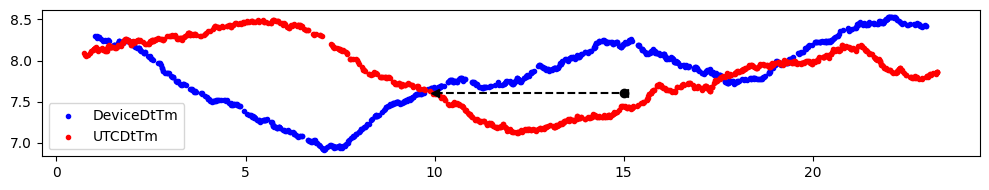

In [ ]:
#reduce data to those with values in both timestamp columns
temp = df_cgm.sample(100000).dropna(subset=['UTCDtTm','DeviceDtTm'],how='any').copy()
temp['DeviceDtTm'] = pd.to_datetime(temp.DeviceDtTm)
temp['UTCDtTm'] = pd.to_datetime(temp.UTCDtTm)

#calculate the hour of day for each timestamp
temp['DeviceDtTm_hod'] = temp.DeviceDtTm.dt.hour+temp.DeviceDtTm.dt.minute/60+temp.DeviceDtTm.dt.second/3600
temp['UTCDtTm_hod'] = temp.UTCDtTm.dt.hour+temp.UTCDtTm.dt.minute/60+temp.UTCDtTm.dt.second/3600

#calcualte centered moving average
window = 2000
cgm_ma_dtm  = temp[['CGMVal','DeviceDtTm_hod']].sort_values('DeviceDtTm_hod').rolling(window=window, min_periods=window, on='DeviceDtTm_hod', center=True).mean().sample(1000)
cgm_ma_utc  = temp[['CGMVal','UTCDtTm_hod']].sort_values('UTCDtTm_hod').rolling(window=window, min_periods=window, on='UTCDtTm_hod', center=True).mean().sample(1000)

#draw
plt.figure(figsize=(10,2)); 
plt.scatter(cgm_ma_dtm.DeviceDtTm_hod, cgm_ma_dtm.CGMVal, label='DeviceDtTm', color='blue', marker='.')
plt.scatter(cgm_ma_utc.UTCDtTm_hod, cgm_ma_utc.CGMVal, label='UTCDtTm', color='red', marker='.')
plt.plot([10,15],[7.6,7.6], color='black', linestyle='--', marker='<')
plt.plot([15],[7.6], color='black', marker='o')
plt.legend(); plt.tight_layout()


From this we can clearly see that when using DeviceDtTm, the curve much better aligns with expected diurnal, postprandial patterns (pronounced peak in the morning, noon and evening). The majority of TmZnOffset values is at around -300 minutes (-5hours) vs. UTC. This shows here as the red curve is 5 hours shifted into the future (At UTC 15:00 we see the morning peak, which really is at around 10:00 (-5h).

Note: The glossary description is misleading.
> UTCDtTm : Device date and time (with timezone offset)  

## Which timezone offsets to use?
Now we know that we need to get timezone offset data for all patients. We could check how many patients have TmZnOffset data which we could use to backward and forward fill. We do this by doing a groupby patient, agg on TmZnOffset using count>100 and a sum() on on the results divided by the group size. This gives us the fraction of patients with at least one TmZnOffset value.

In [ ]:
frac = (df_cgm.groupby('PtID').TmZnOffset.count()>1).sum()/df_cgm.PtID.nunique()
print(f'{frac:.2%} of patients have at least one timezone offset')

37.18% of patients have at least one timezone offset


/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_18177/2353217615.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  frac = (df_cgm.groupby('PtID').TmZnOffset.count()>1).sum()/df_cgm.PtID.nunique()


Text(0.5, 1.0, 'Fraction of non NaN timezone offsets for patients with at least one')

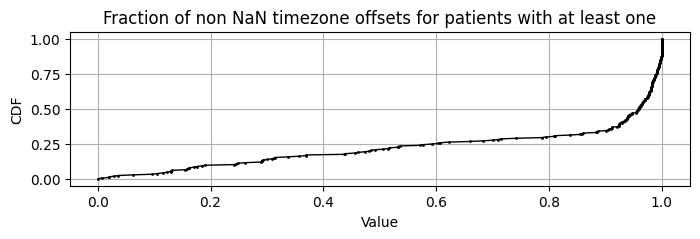

In [ ]:
#check fraction of non NaN offsets for patients with at least one
# df_cgm.PtID = df_cgm.PtID.astype('int')
pts_with_data = df_cgm.dropna(subset=['TmZnOffset'] ).PtID.unique()
temp = df_cgm.loc[df_cgm.PtID.isin(pts_with_data)]
temp = temp.groupby('PtID').TmZnOffset.agg(lambda x: x.notna().mean())
#temp = df_cgm.groupby('PtID').TmZnOffset.agg(lambda x: x.notna().mean())
plt.figure(figsize=(8,2)); ax = plt.gca()
cdf.plot_cdf(temp,ax=ax)
plt.title('Fraction of non NaN timezone offsets for patients with at least one')

This is clearly not enough. Instead, we (as JAEB mentioned), we can also use the local in patient roster to do that while accounting for daylight saving time.
The Patient Roster has a column **PtTimezoneOffset** (Participant’s timezone offset) given in hours. 

Is a static value good enough? How often do TmZnOffset change within a patient?

87.1% of patients have 2 unique time zones or less


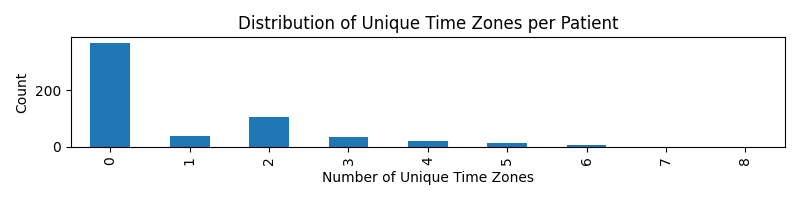

63.0% of patients have shifts of 1 hours or less


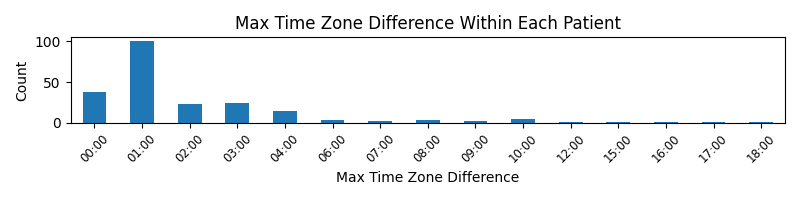

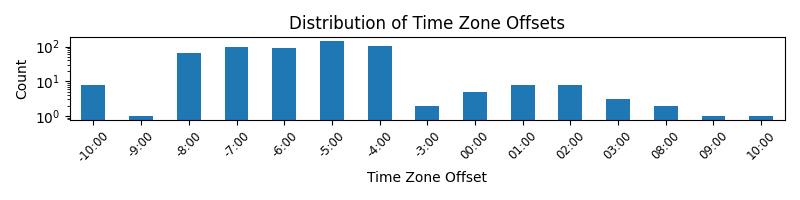

In [ ]:
def timedetla_formatter(td):
    return f"{td.seconds // 3600 + td.days * 24:02d}:{(td.seconds % 3600) // 60:02d}"

#number of time zones per patient
number_time_zones = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.nunique()
number_time_zones = number_time_zones.value_counts().sort_index()
print(f'{100*number_time_zones.loc[0:2].sum()/number_time_zones.sum():2.1f}% of patients have 2 unique time zones or less')

plt.figure(figsize=(8, 2)); ax=plt.gca()
number_time_zones.plot(kind='bar', ax=ax)
plt.xlabel('Number of Unique Time Zones')
plt.ylabel('Count')
plt.title('Distribution of Unique Time Zones per Patient')
plt.tight_layout(); plt.show()


#max difference within a patient
tzdiff_within = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.agg(lambda x: x.max()-x.min())
tzdiff_within = tzdiff_within.value_counts().sort_index()
print(f'{100*tzdiff_within[tzdiff_within.index<=timedelta(hours=1)].sum()/tzdiff_within.sum():2.1f}% of patients have shifts of 1 hours or less')

plt.figure(figsize=(8, 2)); ax=plt.gca()
tzdiff_within.plot(kind='bar', ax=ax)
tick_labels = [timedetla_formatter(x) for x in tzdiff_within.index]
ax.set_xticklabels(tick_labels, rotation=45,fontsize='small')
plt.xlabel('Max Time Zone Difference');plt.ylabel('Count')
plt.title('Max Time Zone Difference Within Each Patient')
plt.tight_layout();plt.show()


#time zone offset distribution
all_time_zones = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.unique().explode()
plt.figure(figsize=(8, 2)); ax=plt.gca()
all_time_zones= all_time_zones.value_counts().sort_index()
all_time_zones.plot(kind='bar', logy=True, ax=ax)
tick_labels = [timedetla_formatter(x) for x in all_time_zones.index]
ax.set_xticklabels(tick_labels, rotation=45,fontsize='small')

plt.xticks(rotation=45, fontsize='small')
plt.xlabel('Time Zone Offset'); plt.ylabel('Count'); plt.title('Distribution of Time Zone Offsets')
plt.tight_layout();plt.show()

We see that most patients experience multiple time zones. And the majority is a change of 1 hour. Likely the result of daylight saving times. But a significant portion experiences more changes of 2,3 or 4 hours or more. This is nothing, that we could account for. While we can remove patients with more frequent changes in `TmZnOffset`, almost 2/3 of the patients have no data in that column. 

* Only 35% of patients come with reported device timezones. For the others, we would need to use the locale provided in the patient roster, which would give a single timezone, pluts daylightsaving = 2 time-zones
* Using a single (or 2 considering DST) time zone might not be good enough. I checked the 35 patients with complete time zone data:
  * 30%of those has more than 2 time zones
  * 40% the shifts are >=2 hours

Conclusion: When we use a static time zone we will roughly get data for which at least ~30% of the patients have at least some wrong local times with ~40% of the errors being >=2hours.

## Onbtaining Local times for all Patients

Now, i want to check how to convert the timezone offset and utc into local times that account for DST. Then, convert the utc times into local times using the Patient roster timezone offsets and compare those with the ones we obtained from the DeviceDtTm with TmZnOffset.

Goal: Get local times, including DST shifts, using patient roster offsets. Also, check how these compare to using the local times provided by DeviceDtTm.
Success: data is converted into local times

Approach:
1. We identify the right tools to do the conversion from utc datetime and offset (hours) into timezone aware objects and converting those into local times reflecting DST changes as well.
2. We convert the data using apply into a new column (datetime) and (datetime_local)
3. We compare the difference between datetime_local and DeviceDtTm. We use a summary statistic. But also look at examples around daylight saving time changes. We plot DeviceDtTm, datetime_local, TmZnOffset.


### Time Zone Libraries

With python 3.9 zoneinfo was introduced that can handle political time zones such as America/New_York following the IANA Time Zone database. the older datetime.timezone class only handles fixed UTC offsets which can not handle DST because DST is a political and regional phaenomenon. 

Use zoneinfo for real-world time zones where DST and geographic names are important (e.g., scheduling systems, international applications).
Use datetime.timezone for simple applications requiring only fixed offsets, like basic UTC conversions or static offsets in logs.

Since the patient Roster only provides fixed offsets from UTC, we can only guess daylight saving times. We could however, try to infer the region from the offset ```offset_to_tz = {-8: "America/Los_Angeles"}```. However, we do not exactly know if the reported UTC offset is the offset during daylight daving time or standard daylight time. 

In [ ]:
from datetime import timezone
now_utc = datetime.now(tz=timezone.utc)
print(now_utc)
now_eastern = now_utc.astimezone(timezone(offset=timedelta(hours=-5)))
print(now_eastern)
now_local = now_eastern.replace(tzinfo=None)
print(now_local)

2024-12-06 14:24:53.635475+00:00
2024-12-06 09:24:53.635475-05:00
2024-12-06 09:24:53.635475


Now, we will get the timestamps for all patients:

1. We forward fill TmZnOffset, when available. 
2. We join PtTimezoneOffset into the df_cgm
3. We fill missing TmZnOffset with PtTimezoneOffset

TODO: check how much Tzinformation exists for patients that have it (coverage).

In [ ]:
# Example using forward filling
data = {
    'patient_id': [2,1, 1, 1,1,1,1 ,2, 2, 2, 2, 2, 2,1],
    'timestamp': [7,1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 7],
    'offset': [None, 
               None, 1, None, 1,None, None, 
               None, None, 2, None, 2, None,
               None],
}
df = pd.DataFrame(data)
display(df.sort_values(['patient_id', 'timestamp']))
df = df.sample(frac=1)


df = df.sort_values('timestamp')
# Apply ffill with limit_area='inside' on a Series for each group
x = df.groupby('patient_id')['offset'].apply(lambda x: x.ffill(limit_area='inside')).reset_index(level=0, drop=True)
df['filled'] = x
display(df.sort_values(['patient_id', 'timestamp']))

In [ ]:
# df_cgm = df_cgm.sort_values('UTCDtTm')
# # Apply ffill with limit_area='inside' on a Series for each group
# x = df_cgm.groupby('PtID')['TmZnOffset'].apply(lambda x: x.ffill(limit_area='inside')).reset_index(level=0, drop=True)
# df_cgm['filled'] = x
# df_cgm.filled.count()/df_cgm.TmZnOffset.count()

### Comparisng patient roster offsets with device reported offsets

In [ ]:
## joining tables
df_patient['PtTimezoneOffset'] = pd.to_timedelta(df_patient.PtTimezoneOffset, unit='hour')
df_cgm = df_cgm.join(df_patient[['PtID','PtTimezoneOffset']].set_index('PtID'), on='PtID', how='left')

Text(0.5, 1.0, 'Difference between CGM TmZnOffset and PtTimezoneOffset')

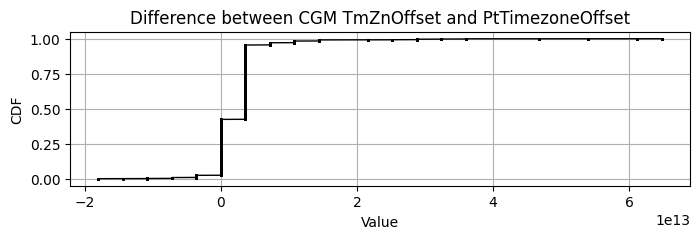

In [ ]:
diff = df_cgm.TmZnOffset - df_cgm.PtTimezoneOffset
plt.figure(figsize=(8, 2)); ax = plt.gca()
cdf.plot_cdf(diff.dropna(),ax=ax)
plt.title('Difference between CGM TmZnOffset and PtTimezoneOffset')

## Estimating local times from patient roster

In [ ]:
df_cgm = df_cgm[['PtID', 'DeviceDtTm', 'UTCDtTm', 'CGMVal', 'TmZnOffset', 'PtTimezoneOffset']]

#method 1: getting localized datetimes
#df_cgm['datetime'] = pd.to_datetime(df_cgm.UTCDtTm, utc=True)
#df_cgm['datetime'] = df_cgm.apply(lambda x: x.datetime.tz_convert(timezone(offset=x.PtTimezoneOffset)), axis=1)

#method 2: or as naive datetime (simply adding the offset)
df_cgm['datetime']= df_cgm.UTCDtTm+ df_cgm.TmZnOffset
display(df_cgm.dropna(subset=['TmZnOffset']).sample(3))

,PtID,DeviceDtTm,UTCDtTm,CGMVal,TmZnOffset,PtTimezoneOffset,datetime
10993295,1153,2018-03-04 15:01:15,2018-03-04 23:01:15,5.66176,-1 days +16:00:00,-1 days +16:00:00,2018-03-04 15:01:15
5623086,976,2018-09-30 09:53:55,2018-09-30 16:53:55,7.49351,-1 days +17:00:00,-1 days +16:00:00,2018-09-30 09:53:55
8930940,355,2019-02-16 00:50:50,2019-02-16 07:50:50,6.77191,-1 days +17:00:00,-1 days +16:00:00,2019-02-16 00:50:50


## Managing File Sizes

Processing patient data requires us to load all files into memory at once because the patient data is spread accross all CGM files. While we could use dask and load patient data iteratively, this would create a lot of overhead. Instead, we convert the data into a paquet format, splitting it by patient id. This allows us to process patients iteratively without requiring all data to be in memory making this a more preformant option overall.

In [ ]:
import dask.dataframe as dd
loop_paquet_path = os.path.join(raw_path, 'paquet', study_name) 

In [ ]:
#all units are in mmol/L, so we can drop the column
ddf = dd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceCGM*.txt'), sep='|', 
                  parse_dates=['UTCDtTm'], date_format='%Y-%m-%d %H:%M:%S', 
                  usecols=['PtID', 'UTCDtTm', 'RecordType', 'CGMVal'])

#unfortunately, the patient data is spread accross all 6 files  so we can't process them in sequence without much overhead. therefore, export as parquet
ddf.to_parquet(loop_paquet_path, partition_on='PtID')

In [ ]:
from dask.distributed import Client
client = Client()
client

/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49757 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:49757/status,
Dashboard: http://127.0.0.1:49757/status,Workers: 4
Total threads: 12,Total memory: 36.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49758,Workers: 4
Dashboard: http://127.0.0.1:49757/status,Total threads: 12
Started: Just now,Total memory: 36.00 GiB
Comm: tcp://127.0.0.1:49769,Total threads: 3
Dashboard: http://127.0.0.1:49773/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:49761,


In [ ]:
ddf = dd.read_parquet(loop_paquet_path, aggregate_files='PtID')
ddf = ddf.rename(columns={'PtID': 'patient_id', 'UTCDtTm': 'UTCDtTm', 'RecordType': 'RecordType', 'CGMVal': 'cgm'})

#drop calibrations
ddf = ddf.loc[ddf.RecordType == 'CGM']
ddf.index = ddf.index.astype('int') #a workaround to obmit error occuring when there were no rows left
ddf = ddf.drop(columns=['RecordType'])

#convert to mg/dL
ddf['cgm'] = ddf.cgm*18.018 

#convert to local datetime
ddf = ddf.set_index('patient_id') # make sure divisions are set correctly
ddf = ddf.join(df_patient[['PtID','PtTimezoneOffset']].set_index('PtID'), how='left')
ddf['datetime'] = ddf.UTCDtTm + dd.to_timedelta(ddf.PtTimezoneOffset, unit='hour')
ddf = ddf.drop(columns=['UTCDtTm', 'PtTimezoneOffset'])

In [ ]:
display(ddf.partitions[0].compute().sort_values(by='datetime').head(10))
#df3 = ddf.loc[3].compute().reset_index(names='patient_id')
transformed = postprocessing.cgm_transform(ddf.partitions[0].compute())
display(transformed.head(10))

/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 12.25 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


,cgm,datetime
3,396.516721,2018-06-15 19:01:43
3,394.273480,2018-06-15 19:06:44
3,387.947360,2018-06-15 19:11:44
3,338.812274,2018-06-15 19:21:44
3,331.772641,2018-06-15 19:26:48
3,325.617692,2018-06-15 19:31:44
3,345.612267,2018-06-15 19:41:44
3,351.902351,2018-06-15 19:46:43
3,355.098744,2018-06-15 19:51:44
3,356.289734,2018-06-15 19:56:43


/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 12.25 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


,datetime,cgm
0,2018-06-15 19:00:00,396.516721
1,2018-06-15 19:05:00,394.273480
2,2018-06-15 19:10:00,387.947360
3,2018-06-15 19:15:00,NaN
4,2018-06-15 19:20:00,338.812274
5,2018-06-15 19:25:00,331.772641
6,2018-06-15 19:30:00,325.617692
7,2018-06-15 19:35:00,NaN
8,2018-06-15 19:40:00,345.612267
9,2018-06-15 19:45:00,351.902351


### post process all CGM data using dask map_partition
TODO: CHeck if groupby patient_id also works as a safer? alternative?

In [ ]:
loop_cgm_transformed = ddf.map_partitions(postprocessing.cgm_transform)

In [ ]:
transformed_partition = loop_cgm_transformed.get_partition(0).compute()
display(transformed_partition.head(10))

/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 12.27 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


,datetime,cgm
0,2018-06-15 19:00:00,396.516721
1,2018-06-15 19:05:00,394.273480
2,2018-06-15 19:10:00,387.947360
3,2018-06-15 19:15:00,NaN
4,2018-06-15 19:20:00,338.812274
5,2018-06-15 19:25:00,331.772641
6,2018-06-15 19:30:00,325.617692
7,2018-06-15 19:35:00,NaN
8,2018-06-15 19:40:00,345.612267
9,2018-06-15 19:45:00,351.902351


In [ ]:
# export as CSV and parquet
loop_parquet_out_path = os.path.join(out_path, 'parquet', study_name)
loop_cgm_transformed.to_parquet(os.path.join(loop_parquet_out_path, 'cgm_transformed'))
loop_cgm_transformed.to_csv(os.path.join(loop_parquet_out_path, 'cgm_transformed.csv'));

/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 12.87 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


['/Users/jan/git/nudgebg/egvinsulin/data/out/parquet/Loop study public dataset 2023-01-31/cgm_transformed.csv/000.part',
 '/Users/jan/git/nudgebg/egvinsulin/data/out/parquet/Loop study public dataset 2023-01-31/cgm_transformed.csv/001.part',
 '/Users/jan/git/nudgebg/egvinsulin/data/out/parquet/Loop study public dataset 2023-01-31/cgm_transformed.csv/002.part',
 '/Users/jan/git/nudgebg/egvinsulin/data/out/parquet/Loop study public dataset 2023-01-31/cgm_transformed.csv/003.part',
 '/Users/jan/git/nudgebg/egvinsulin/data/out/parquet/Loop study public dataset 2023-01-31/cgm_transformed.csv/004.part',
 '/Users/jan/git/nudgebg/egvinsulin/data/out/parquet/Loop study public dataset 2023-01-31/cgm_transformed.csv/005.part',
 '/Users/jan/git/nudgebg/egvinsulin/data/out/parquet/Loop study public dataset 2023-01-31/cgm_transformed.csv/006.part',
 '/Users/jan/git/nudgebg/egvinsulin/data/out/parquet/Loop study public dataset 2023-01-31/cgm_transformed.csv/007.part',
 '/Users/jan/git/nudgebg/egvinsu